In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os

In [2]:
from pathlib import Path

# Configurable parts
SYMBOL = "USDJPY"
DOLLAR_THRESHOLD = "115009542m"

START_DATE = "20210101"
END_DATE = "20241231"

# Build base name
RESAMPLED_NAME = f"{SYMBOL}-{DOLLAR_THRESHOLD}-dollar-{START_DATE}-{END_DATE}"

# Base directories
BASE_DIR = Path("../data")
RESAMPLED_DIR = BASE_DIR / "resampled"
PROCESSED_DIR = BASE_DIR / "processed"

# Final paths
RESAMPLED_FILE_PATH = RESAMPLED_DIR / f"{RESAMPLED_NAME}.pkl"
PROCESSED_FILE_PATH = PROCESSED_DIR / f"{RESAMPLED_NAME}-processed.pkl"

In [3]:
EVENT_NAME = 'cusum_filter'
DIRECTION_LABEL_DIR = BASE_DIR / "direction_labels"
DIRECTION_LABEL_DIR.mkdir(parents=True, exist_ok=True)
DIRECTION_LABEL_FILE_PATH = DIRECTION_LABEL_DIR / f"{RESAMPLED_NAME}-{EVENT_NAME}.pkl"

In [4]:
%%time
df = pd.read_pickle(PROCESSED_FILE_PATH)

CPU times: user 646 μs, sys: 33.9 ms, total: 34.6 ms
Wall time: 50 ms


In [5]:
df.shape

(832151, 48)

In [6]:
df.head()

,open,high,low,close,volume,spread,close_delta,close_return,close_log_return,ret_mean_5,...,dom,month,hour_sin,hour_cos,dow_sin,dow_cos,dom_sin,dom_cos,month_sin,month_cos
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-04 02:13:07.071,103.0510,103.0585,103.0305,103.0525,1.118770e+12,0.003031,0.0025,0.000024,0.000024,-0.000121,...,4,1,0.5,0.866025,0.0,1.0,0.724793,0.688967,0.5,0.866025
2021-01-04 02:22:14.974,103.0520,103.0655,103.0365,103.0365,1.117670e+12,0.002791,-0.0160,-0.000155,-0.000155,-0.000082,...,4,1,0.5,0.866025,0.0,1.0,0.724793,0.688967,0.5,0.866025
2021-01-04 02:29:58.781,103.0370,103.0455,103.0090,103.0195,1.120180e+12,0.002957,-0.0170,-0.000165,-0.000165,-0.000072,...,4,1,0.5,0.866025,0.0,1.0,0.724793,0.688967,0.5,0.866025
2021-01-04 02:39:51.245,103.0185,103.0355,102.9995,103.0145,1.118270e+12,0.002706,-0.0050,-0.000049,-0.000049,-0.000075,...,4,1,0.5,0.866025,0.0,1.0,0.724793,0.688967,0.5,0.866025
2021-01-04 02:48:03.646,103.0140,103.0220,102.9675,103.0035,1.117380e+12,0.002347,-0.0110,-0.000107,-0.000107,-0.000090,...,4,1,0.5,0.866025,0.0,1.0,0.724793,0.688967,0.5,0.866025


In [7]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'spread', 'close_delta',
       'close_return', 'close_log_return', 'ret_mean_5', 'ret_mean_10',
       'log_volume', 'ema5', 'ema5_slope', 'ema20', 'ema20_slope', 'atr14',
       'atr20', 'vol_adj_return', 'close_to_atr', 'bb_upper', 'bb_lower',
       'bb_mavg', 'bb_width', 'bb_position', 'donchian_upper',
       'donchian_lower', 'donchian_mid', 'donchian_width', 'stoch_k',
       'stoch_d', 'rsi14', 'macd', 'macd_signal', 'macd_diff', 'unix_time',
       'hour', 'dow', 'dom', 'month', 'hour_sin', 'hour_cos', 'dow_sin',
       'dow_cos', 'dom_sin', 'dom_cos', 'month_sin', 'month_cos'],
      dtype='object')

## Calculate Daily Volatility

In [8]:
vol = df['close_log_return'].rolling(window=60).std()
vol.mean()

np.float64(0.00018770542062345876)

## Get Events Start Time (t0)

In [9]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def get_tevents_optimized(data: pd.Series, threshold: float) -> pd.DatetimeIndex:
    # get tEvents using CUSUM filter
    values = data.values
    timestamps = data.index

    s_pos = np.zeros_like(values)
    s_neg = np.zeros_like(values)

    t_events_mask = np.zeros_like(values, dtype=bool)

    cum_pos, cum_neg = 0.0, 0.0

    for i in tqdm(range(len(values))):
        cum_pos = max(0.0, cum_pos + values[i])
        cum_neg = min(0.0, cum_neg + values[i])
        s_pos[i] = cum_pos
        s_neg[i] = cum_neg

        if cum_pos > threshold:
            t_events_mask[i] = True
            cum_pos = 0.0
        if cum_neg < -threshold:
            t_events_mask[i] = True
            cum_neg = 0.0

    return timestamps[t_events_mask]


In [10]:
%%time

t_events = get_tevents_optimized(df['close_log_return'].iloc[1:], threshold=vol.mean()*2.0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 832150/832150 [00:00<00:00, 3416373.42it/s]

CPU times: user 246 ms, sys: 9.11 ms, total: 255 ms
Wall time: 254 ms


In [11]:
t_events

DatetimeIndex(['2021-01-04 02:48:03.646000', '2021-01-04 03:46:15.759000',
               '2021-01-04 04:22:33.521000', '2021-01-04 05:20:16.974000',
               '2021-01-04 05:59:22.414000', '2021-01-04 06:49:53.825000',
               '2021-01-04 07:13:23.263000', '2021-01-04 07:41:33.568000',
               '2021-01-04 07:52:48.585000', '2021-01-04 08:11:27.061000',
               ...
               '2024-12-30 20:04:05.484000', '2024-12-30 20:29:13.447000',
               '2024-12-30 20:34:56.513000', '2024-12-30 20:55:46.417000',
               '2024-12-30 21:06:58.409000', '2024-12-30 21:48:03.683000',
               '2024-12-30 23:10:19.118000', '2024-12-30 23:30:41.755000',
               '2024-12-30 23:36:09.864000', '2024-12-30 23:42:19.687000'],
              dtype='datetime64[ns]', name='timestamp', length=150132, freq=None)

In [12]:
df.loc[t_events]

,open,high,low,close,volume,spread,close_delta,close_return,close_log_return,ret_mean_5,...,dom,month,hour_sin,hour_cos,dow_sin,dow_cos,dom_sin,dom_cos,month_sin,month_cos
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-04 02:48:03.646,103.0140,103.0220,102.9675,103.0035,1.117380e+12,0.002347,-0.0110,-0.000107,-0.000107,-0.000090,...,4,1,0.500000,0.866025,0.0,1.0,0.724793,0.688967,5.000000e-01,0.866025
2021-01-04 03:46:15.759,102.9670,102.9775,102.9380,102.9430,1.119830e+12,0.002287,-0.0250,-0.000243,-0.000243,-0.000118,...,4,1,0.707107,0.707107,0.0,1.0,0.724793,0.688967,5.000000e-01,0.866025
2021-01-04 04:22:33.521,102.9570,103.0080,102.9540,103.0000,1.117600e+12,0.002342,0.0435,0.000423,0.000422,0.000029,...,4,1,0.866025,0.500000,0.0,1.0,0.724793,0.688967,5.000000e-01,0.866025
2021-01-04 05:20:16.974,103.0200,103.0640,103.0165,103.0560,1.121710e+12,0.003042,0.0360,0.000349,0.000349,0.000109,...,4,1,0.965926,0.258819,0.0,1.0,0.724793,0.688967,5.000000e-01,0.866025
2021-01-04 05:59:22.414,103.0285,103.0315,102.9955,103.0080,1.125240e+12,0.003031,-0.0200,-0.000194,-0.000194,0.000032,...,4,1,0.965926,0.258819,0.0,1.0,0.724793,0.688967,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 21:48:03.683,156.8250,156.8685,156.8250,156.8615,7.332900e+11,0.011787,0.0360,0.000230,0.000230,0.000077,...,30,12,-0.707107,0.707107,0.0,1.0,-0.201299,0.979530,-2.449294e-16,1.000000
2024-12-30 23:10:19.118,156.9105,156.9640,156.9090,156.9635,7.369500e+11,0.022684,0.0545,0.000347,0.000347,0.000132,...,30,12,-0.258819,0.965926,0.0,1.0,-0.201299,0.979530,-2.449294e-16,1.000000
2024-12-30 23:30:41.755,157.0125,157.0325,157.0115,157.0315,7.345500e+11,0.012037,0.0200,0.000127,0.000127,0.000190,...,30,12,-0.258819,0.965926,0.0,1.0,-0.201299,0.979530,-2.449294e-16,1.000000


## Calculate Target Volatility (trgt)
This will be used for the calculation of dynamic TP/SL

In [13]:
def get_daily_vol(close,span0=100):
    # daily vol reindexed to close
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    #bp()
    df0=df0[df0>0]
    #bp()
    df0=(pd.Series(close.index[df0-1],
                   index=close.index[close.shape[0]-df0.shape[0]:]))
    #bp()
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily rets
    except Exception as e:
        print(e)
        print('adjusting shape of close.loc[df0.index]')
        cut = close.loc[df0.index].shape[0] - close.loc[df0.values].shape[0]
        df0=close.loc[df0.index].iloc[:-cut]/close.loc[df0.values].values-1
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    return df0

In [16]:
from ta.volatility import AverageTrueRange

def get_atr(df, window=60):
    atr = AverageTrueRange(high=df['high'], low=df['low'], close=df['close'], window=window)
    return atr.average_true_range().rename(f"atr{window}")

CPU times: user 1.49 s, sys: 34.1 ms, total: 1.52 s
Wall time: 1.53 s


<Axes: title={'center': 'ATR on Dollar Bars'}, xlabel='timestamp'>

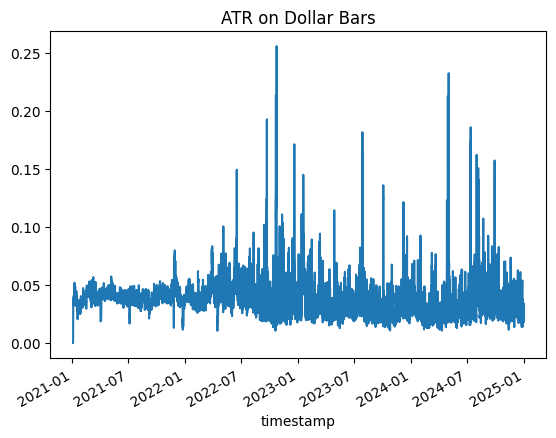

In [17]:
%%time
atr60 = get_atr(df, window=60)
atr60.describe()
atr60.plot(title='ATR on Dollar Bars')

In [19]:
def get_intraday_vol(log_return, window=60, span=60):
    rolling_std = log_return.rolling(window=window).std()
    smoothed_vol = rolling_std.ewm(span=span).mean()
    return smoothed_vol.rename(f'intraday_vol_{window}_{span}')

In [46]:
trgt = get_daily_vol(df['close']).reindex(t_events, method='ffill')

In [18]:
trgt = get_atr(df, window=60).reindex(t_events, method='ffill')

count    150132.000000
mean          0.042359
std           0.019901
min           0.000000
25%           0.030904
50%           0.038081
75%           0.047353
max           0.255646
Name: atr60, dtype: float64

In [21]:
trgt = get_intraday_vol(df['close_log_return'], window=60, span=60).reindex(t_events, method='ffill')

count    150118.000000
mean          0.000225
std           0.000122
min           0.000037
25%           0.000154
50%           0.000199
75%           0.000257
max           0.001753
Name: intraday_vol_60_60, dtype: float64

In [47]:
trgt.describe()

count    150089.000000
mean          0.001495
std           0.001104
min           0.000127
25%           0.000842
50%           0.001212
75%           0.001785
max           0.013952
Name: dailyVol, dtype: float64

## Apply Triple Barrier
We use daily volatility to calculate TP/SL, and we set our T1 as 1day

In [48]:
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import pandas as pd

def applyPtSlOnT1(close,events,ptSl,molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_=events.loc[molecule]
    out=events_[['t1']].copy(deep=True)
    
    pt = ptSl[0] * events_['trgt'] if ptSl[0] > 0 else pd.Series(index=events.index)
    sl = -ptSl[1] * events_['trgt'] if ptSl[1] > 0 else pd.Series(index=events.index)

        
    for loc, t1 in events_['t1'].fillna(close.index[-1]).items():
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking
        
    return out


def parallel_apply(func, items, num_threads=4, **kwargs):
    
    def worker(molecule):
        return func(molecule=molecule, **kwargs)

    chunks = np.array_split(items, num_threads)
    
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        results = list(executor.map(worker, chunks))

    return pd.concat(results).sort_index()


def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads=4, t1=False, side=None):
    # Step 1: Filter targets
    trgt = trgt.loc[tEvents]
    trgt = trgt[trgt > minRet]

    # Step 2: Set vertical barrier (t1)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents)

    # Step 3: Build events DataFrame
    if side is None:
        side_, ptSl_ = pd.Series(1., index=trgt.index), [ptSl[0], ptSl[0]]
    else:
        side_, ptSl_ = side.loc[trgt.index], ptSl[:2]

    events = pd.concat({'t1': t1, 'trgt': trgt, 'side': side_}, axis=1).dropna(subset=['trgt'])

    # Step 4: Apply barriers in parallel
    df0 = parallel_apply(
        func=applyPtSlOnT1,
        items=events.index,
        num_threads=numThreads,
        close=close,
        events=events,
        ptSl=ptSl_
    )

    # Step 5: Choose the first touched barrier
    events['t1'] = df0.dropna(how='all').min(axis=1)
    
    if side is None:
        events = events.drop('side', axis=1)
        
    return events


In [49]:
def get_vertical_barrier(t_events, close, delta=pd.Timedelta(minutes=60)):
    """
    For each event in t_events, find the timestamp in close.index 
    that is at least delta later. Returns a pd.Series of t1.
    """
    barrier_times = t_events + delta
    t1_idx = close.index.searchsorted(barrier_times)
    valid_idx = t1_idx[t1_idx < len(close)]
    t1 = pd.Series(close.index[valid_idx], index=t_events[:len(valid_idx)])
    return t1

In [82]:
t1 = get_vertical_barrier(t_events, df['close'], delta=pd.Timedelta(minutes=3.0*60))

In [83]:
t1

timestamp
2021-01-04 02:48:03.646   2021-01-04 05:50:18.483
2021-01-04 03:46:15.759   2021-01-04 06:49:53.825
2021-01-04 04:22:33.521   2021-01-04 07:27:47.993
2021-01-04 05:20:16.974   2021-01-04 08:21:28.069
2021-01-04 05:59:22.414   2021-01-04 09:03:23.133
                                    ...          
2024-12-30 20:01:55.804   2024-12-30 23:06:02.364
2024-12-30 20:04:05.484   2024-12-30 23:06:02.364
2024-12-30 20:29:13.447   2024-12-30 23:30:41.755
2024-12-30 20:34:56.513   2024-12-30 23:36:09.864
2024-12-30 20:55:46.417   2024-12-30 23:58:06.649
Name: timestamp, Length: 150126, dtype: datetime64[ns]

## Calculate minRet

In [84]:
min_ret = 0.5 * intraday_vol.median()
min_ret

np.float64(8.406789125491097e-05)

In [85]:
%%time

events = getEvents(
    df['close'],
    tEvents=t_events, 
    ptSl=[1,1], 
    trgt=trgt, 
    minRet=0, 
    numThreads=16, 
    t1=t1, 
    side=None
)

CPU times: user 40.5 s, sys: 3.21 s, total: 43.7 s
Wall time: 40.7 s


In [86]:
events

,t1,trgt
timestamp,,
2021-01-05 03:14:20.685,2021-01-05 03:41:30.972,0.000139
2021-01-05 04:02:00.143,2021-01-05 05:02:50.361,0.000163
2021-01-05 05:02:50.361,2021-01-05 06:18:30.344,0.000455
2021-01-05 05:37:34.521,2021-01-05 08:38:02.817,0.000734
2021-01-05 06:18:30.344,2021-01-05 09:08:30.319,0.000793
...,...,...
2024-12-30 21:48:03.683,2024-12-30 23:15:58.082,0.000831
2024-12-30 23:10:19.118,NaT,0.000773
2024-12-30 23:30:41.755,NaT,0.000783


In [87]:
events['duration'] = events['t1'] - events.index
events['duration'].describe()

count                       150085
mean     0 days 01:28:48.136466342
std      0 days 03:56:14.324865388
min         0 days 00:00:08.450000
25%         0 days 00:16:02.448000
50%         0 days 00:43:07.595000
75%         0 days 02:08:45.025000
max         3 days 02:50:23.405000
Name: duration, dtype: object

In [88]:
longest_idx = events['duration'].idxmax()
longest_event = events.loc[longest_idx]
print(f"Longest event index: {longest_idx}")
print(longest_event)

Longest event index: 2023-12-29 19:10:35.171000
t1          2024-01-01 22:00:58.576000
trgt                          0.001913
duration        3 days 02:50:23.405000
Name: 2023-12-29 19:10:35.171000, dtype: object


# Keep only intraday events

In [89]:
events = events[events.index.date==events.t1.dt.date]

## Create classification labels

In [90]:
def getBins(events, close, t1=None):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    -t1 is original vertical barrier series
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    # 1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')
    # 2) create out object
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[
        events_.index] - 1
    if 'side' in events_: out['ret'] *= events_['side']  # meta-labeling
    out['bin'] = np.sign(out['ret'])

    if 'side' not in events_:
        # only applies when not meta-labeling.
        # to update bin to 0 when vertical barrier is touched, we need the
        # original vertical barrier series since the events['t1'] is the time
        # of first touch of any barrier and not the vertical barrier
        # specifically. The index of the intersection of the vertical barrier
        # values and the events['t1'] values indicate which bin labels needs
        # to be turned to 0.
        vtouch_first_idx = events[events['t1'].isin(t1.values)].index
        out.loc[vtouch_first_idx, 'bin'] = 0.

    if 'side' in events_: out.loc[out['ret'] <= 0, 'bin'] = 0  # meta-labeling
    return out

In [91]:
labels = getBins(events, df['close'], t1=t1)
labels["bin_class"] = labels["bin"] + 1
labels

,ret,bin,bin_class
timestamp,,,
2021-01-05 03:14:20.685,-0.000228,-1.0,0.0
2021-01-05 04:02:00.143,-0.000286,-1.0,0.0
2021-01-05 05:02:50.361,-0.000490,0.0,1.0
2021-01-05 05:37:34.521,-0.000185,0.0,1.0
2021-01-05 06:18:30.344,-0.000903,-1.0,0.0
...,...,...,...
2024-12-30 20:29:13.447,-0.000592,-1.0,0.0
2024-12-30 20:34:56.513,-0.000621,-1.0,0.0
2024-12-30 20:55:46.417,0.000867,1.0,2.0


In [92]:
labels.bin.value_counts()

bin
 1.0    49480
-1.0    49380
 0.0    45927
Name: count, dtype: int64

In [93]:
labeled_events = events.join(labels, how='inner')

In [94]:
labeled_events.head()

,t1,trgt,duration,ret,bin,bin_class
timestamp,,,,,,
2021-01-05 03:14:20.685,2021-01-05 03:41:30.972,0.000139,0 days 00:27:10.287000,-0.000228,-1.0,0.0
2021-01-05 04:02:00.143,2021-01-05 05:02:50.361,0.000163,0 days 01:00:50.218000,-0.000286,-1.0,0.0
2021-01-05 05:02:50.361,2021-01-05 06:18:30.344,0.000455,0 days 01:15:39.983000,-0.000490,0.0,1.0
2021-01-05 05:37:34.521,2021-01-05 08:38:02.817,0.000734,0 days 03:00:28.296000,-0.000185,0.0,1.0
2021-01-05 06:18:30.344,2021-01-05 09:08:30.319,0.000793,0 days 02:49:59.975000,-0.000903,-1.0,0.0


In [95]:
df.loc[labeled_events.index]

,open,high,low,close,volume,spread,close_delta,close_return,close_log_return,ret_mean_5,...,dom,month,hour_sin,hour_cos,dow_sin,dow_cos,dom_sin,dom_cos,month_sin,month_cos
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-05 03:14:20.685,103.1205,103.1270,103.0725,103.0725,1.124220e+12,0.002356,-0.0480,-0.000465,-0.000466,-0.000127,...,5,1,0.707107,7.071068e-01,0.781831,0.62349,0.848644,0.528964,5.000000e-01,0.866025
2021-01-05 04:02:00.143,103.0540,103.0540,103.0150,103.0150,1.117890e+12,0.002673,-0.0380,-0.000369,-0.000369,-0.000138,...,5,1,0.866025,5.000000e-01,0.781831,0.62349,0.848644,0.528964,5.000000e-01,0.866025
2021-01-05 05:02:50.361,103.0225,103.0235,102.9750,102.9855,1.117630e+12,0.003188,-0.0365,-0.000354,-0.000354,-0.000070,...,5,1,0.965926,2.588190e-01,0.781831,0.62349,0.848644,0.528964,5.000000e-01,0.866025
2021-01-05 05:37:34.521,102.9650,102.9675,102.9420,102.9420,1.118590e+12,0.003252,-0.0240,-0.000233,-0.000233,-0.000084,...,5,1,0.965926,2.588190e-01,0.781831,0.62349,0.848644,0.528964,5.000000e-01,0.866025
2021-01-05 06:18:30.344,102.9600,102.9720,102.9260,102.9350,1.117410e+12,0.002350,-0.0230,-0.000223,-0.000223,-0.000060,...,5,1,1.000000,6.123234e-17,0.781831,0.62349,0.848644,0.528964,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 20:29:13.447,156.9880,156.9890,156.9740,156.9760,7.356900e+11,0.006564,-0.0110,-0.000070,-0.000070,-0.000028,...,30,12,-0.866025,5.000000e-01,0.000000,1.00000,-0.201299,0.979530,-2.449294e-16,1.000000
2024-12-30 20:34:56.513,156.9510,156.9520,156.8830,156.8830,7.346700e+11,0.006558,-0.0680,-0.000433,-0.000433,-0.000141,...,30,12,-0.866025,5.000000e-01,0.000000,1.00000,-0.201299,0.979530,-2.449294e-16,1.000000
2024-12-30 20:55:46.417,156.8770,156.8780,156.8075,156.8275,7.336800e+11,0.006457,-0.0505,-0.000322,-0.000322,-0.000109,...,30,12,-0.866025,5.000000e-01,0.000000,1.00000,-0.201299,0.979530,-2.449294e-16,1.000000


## Calculate Concurrency

In [96]:
def get_concurrency(events, price_index):
    """
    Calculate concurrency: number of overlapping events at each time.
    
    Args:
        events (pd.DataFrame): Must have 't1' column with index as start time.
        price_index (pd.DatetimeIndex): Full time index (e.g., from your OHLCV data).
        
    Returns:
        pd.Series: concurrency count indexed by time.
    """
    concurrency = pd.Series(0, index=price_index)

    for start, end in events['t1'].items():
        concurrency[start:end] += 1

    return concurrency


In [97]:
# Let's say your OHLCV data or close series has this index
price_index = df.index  # or df_ohlcv.index

concurrency = get_concurrency(events=labeled_events, price_index=price_index)

(array([7.06545e+05, 9.93850e+04, 1.84050e+04, 4.93700e+03, 1.55100e+03,
        6.92000e+02, 2.33000e+02, 1.90000e+02, 6.80000e+01, 1.45000e+02]),
 array([  0. ,  15.3,  30.6,  45.9,  61.2,  76.5,  91.8, 107.1, 122.4,
        137.7, 153. ]),
 <BarContainer object of 10 artists>)

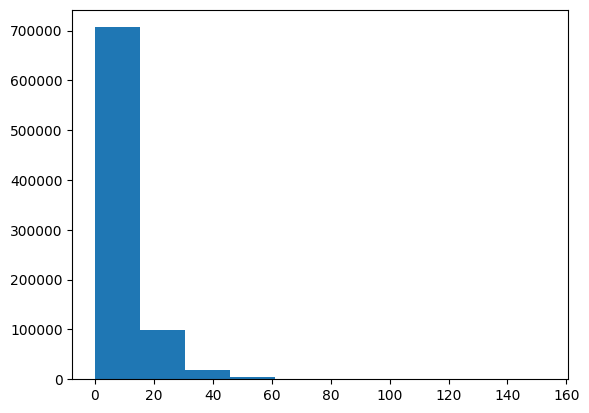

In [98]:
plt.hist(concurrency)

## Save events to disk

In [99]:
labeled_events.to_pickle(DIRECTION_LABEL_FILE_PATH)